In [256]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats

# Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    RandomizedSearchCV,
    KFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,

)
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# hyperparameter tuning
import optuna

In [2]:
try:
    kaggle_train_file_loc = "../input/playground-series-s4e11/train.csv"
    kaggle_test_file_loc = "../input/playground-series-s4e11/test.csv"
    df = pd.read_csv(kaggle_train_file_loc, index_col=0)
    df_test = pd.read_csv(kaggle_test_file_loc, index_col=0)

except:
    github_train_file_loc = "./dataset/train.csv"
    github_test_file_loc = "./dataset/test.csv"
    df = pd.read_csv(github_train_file_loc, index_col=0)
    df_test = pd.read_csv(github_test_file_loc, index_col=0)

In [4]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
df.shape

(58645, 12)

person_age: Age of a person who applies for loan
person_income: the yearly income of the person applying for loan
person_home_ownership:
person_emp_length:


In [21]:
df["loan_status"].value_counts() / df.shape[0]

loan_status
0    0.857618
1    0.142382
Name: count, dtype: float64

# Exploratory Data Analysis

In [10]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/mi

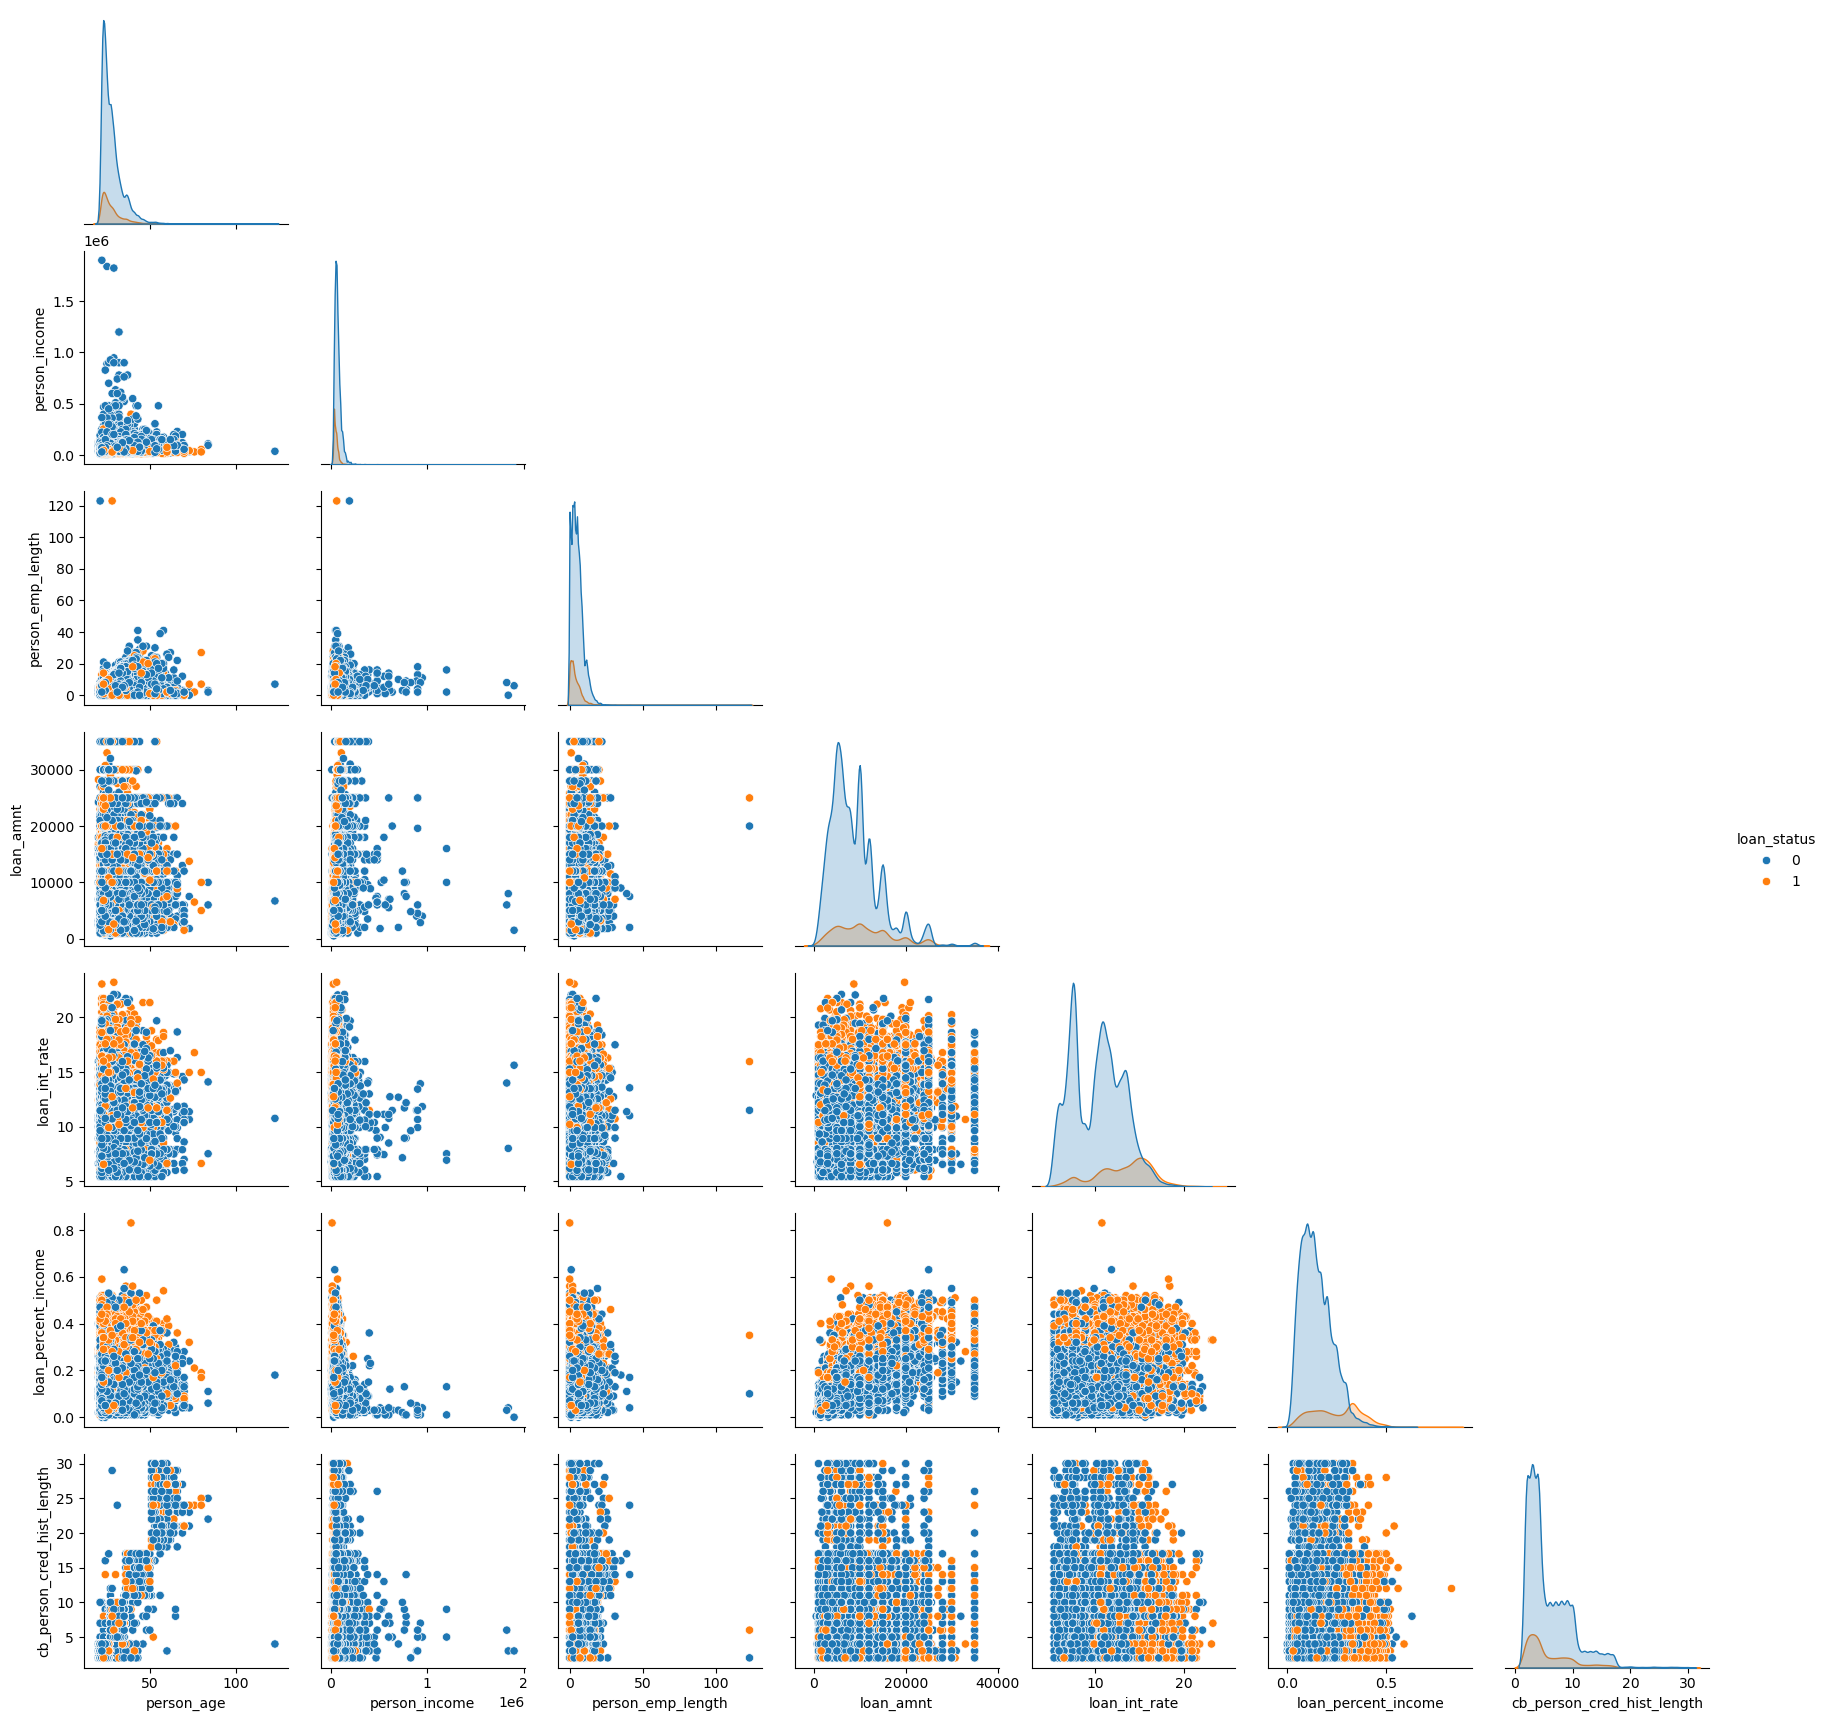

In [29]:
sns.pairplot(df, hue='loan_status', diag_kind='kde', corner=True)

<Axes: >

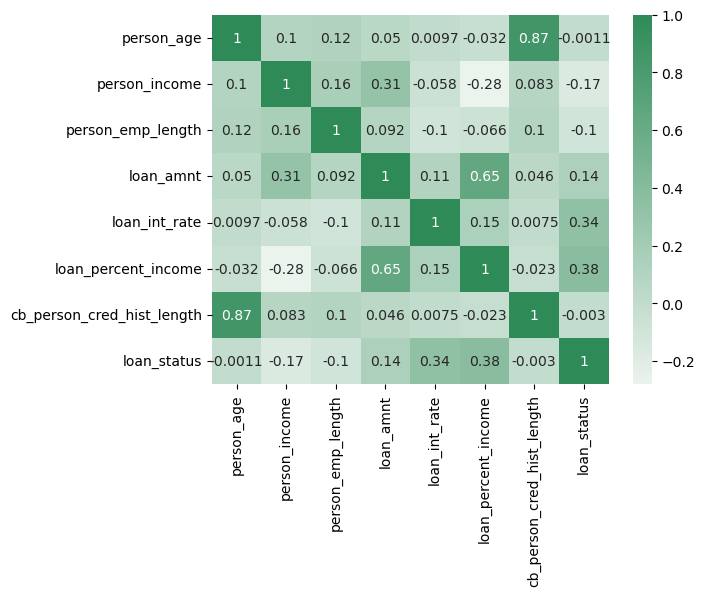

In [51]:
sns.heatmap(
    data=df.select_dtypes(np.number).corr(), 
    cmap=sns.light_palette("seagreen", as_cmap=True), annot=True
)

In [52]:
df.select_dtypes('object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
id,,,,
0,RENT,EDUCATION,B,N
1,OWN,MEDICAL,C,N
2,OWN,PERSONAL,A,N
3,RENT,VENTURE,B,N
4,RENT,MEDICAL,A,N
...,...,...,...,...
58640,MORTGAGE,EDUCATION,D,Y
58641,RENT,MEDICAL,C,N
58642,RENT,EDUCATION,D,N


/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


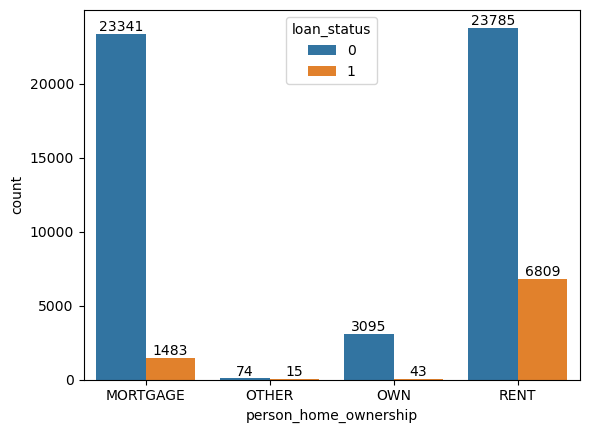

In [ ]:
data_plot = df.groupby(["loan_status", "person_home_ownership"])[["person_age"]].agg("count")
data_plot = data_plot.reset_index()
data_plot = data_plot.rename(columns={"person_age":"count"})


fig, ax = plt.subplots()
sns.barplot(data=data_plot, x='person_home_ownership', y='count', hue='loan_status', ax=ax)
for i in ax.containers:
    ax.bar_label(i, label_type="edge")


/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


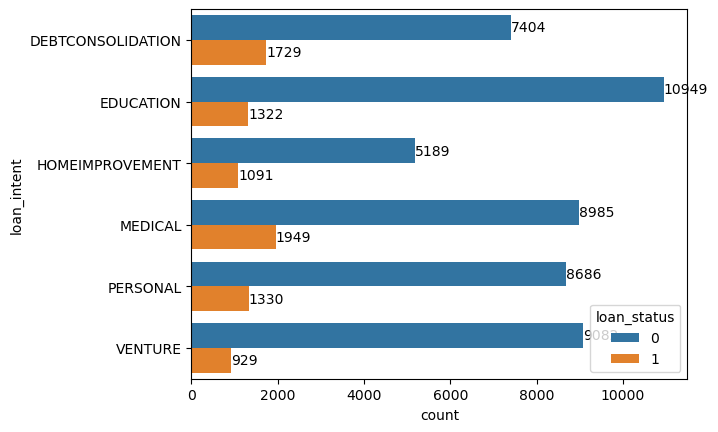

In [74]:
data_plot = df.groupby(["loan_status", "loan_intent"])[["person_age"]].agg("count")
data_plot = data_plot.reset_index()
data_plot = data_plot.rename(columns={"person_age": "count"})

fig, ax = plt.subplots()
sns.barplot(data=data_plot, x='count', y='loan_intent', hue='loan_status', ax=ax)
for i in ax.containers:
    ax.bar_label(i, label_type="edge")

/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


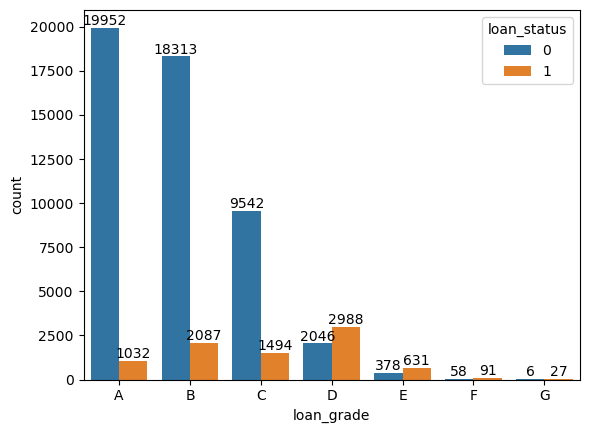

In [75]:
data_plot = df.groupby(["loan_status", "loan_grade"])[["person_age"]].agg("count")
data_plot = data_plot.reset_index()
data_plot = data_plot.rename(columns={"person_age":"count"})


fig, ax = plt.subplots()
sns.barplot(data=data_plot, x='loan_grade', y='count', hue='loan_status', ax=ax)
for i in ax.containers:
    ax.bar_label(i, label_type="edge")

/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tim/miniforge3/envs/for_ml/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


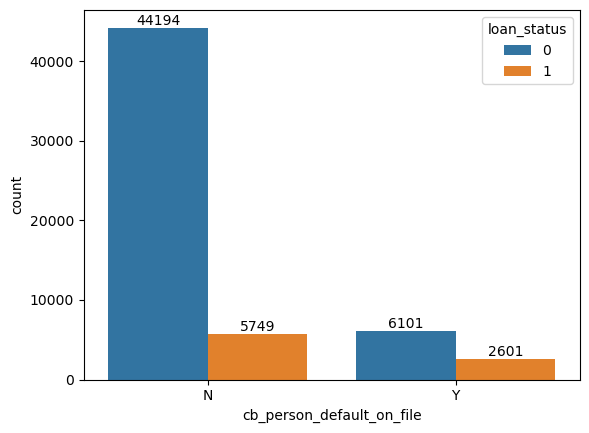

In [ ]:
data_plot = df.groupby(["loan_status", "cb_person_default_on_file"])[["person_age"]].agg("count")
data_plot = data_plot.reset_index()
data_plot = data_plot.rename(columns={"person_age": "count"})


fig, ax = plt.subplots()
sns.barplot(data=data_plot, x="cb_person_default_on_file", y="count", hue="loan_status", ax=ax)
for i in ax.containers:
    ax.bar_label(i, label_type="edge")

In [192]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [199]:
pt = PowerTransformer(method='yeo-johnson')
# pt = StandardScaler()

test = pt.fit_transform(np.array(df["cb_person_cred_hist_length"]).reshape(-1, 1))

<Axes: xlabel='cb_person_cred_hist_length', ylabel='Count'>

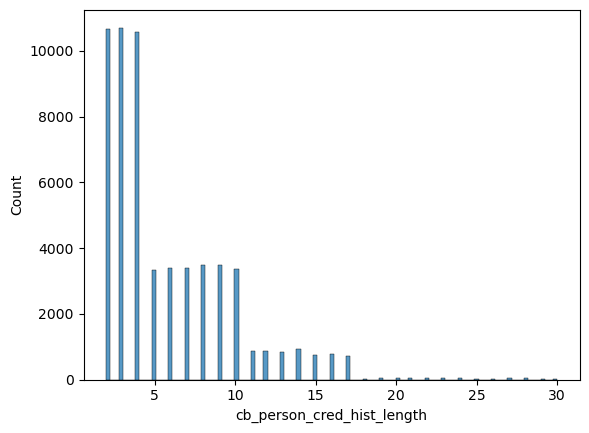

In [201]:
sns.histplot(df, x="cb_person_cred_hist_length")

<Axes: ylabel='Count'>

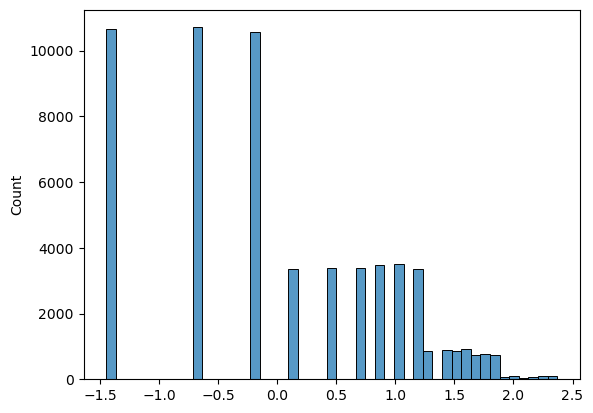

In [202]:
sns.histplot(x=test.flatten())

In [207]:
result = pd.DataFrame(test.flatten())
result[0].mean(), result[0].var(), result[0].skew(), result[0].kurt()

(6.932774378070241e-16,
 1.0000170520428346,
 0.0932910957783511,
 -1.0867872683391022)

In [208]:
orig = df["loan_percent_income"]
orig.mean(), orig.var(), orig.skew(), orig.kurt()

(0.15923751385454857,
 0.008407384910127548,
 0.9174730236540014,
 0.63134251859743)

In [205]:
df[df["person_emp_length"] == 0]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
7,21,20000,RENT,0.0,PERSONAL,C,2500,13.49,0.13,Y,3,0
9,35,110000,MORTGAGE,0.0,DEBTCONSOLIDATION,C,15000,12.98,0.14,Y,6,0
20,28,45000,OWN,0.0,PERSONAL,A,3200,7.88,0.07,N,5,0
38,30,54000,RENT,0.0,MEDICAL,B,12500,11.71,0.24,N,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
58607,44,76000,RENT,0.0,MEDICAL,C,14000,13.16,0.18,Y,13,0
58614,22,75000,MORTGAGE,0.0,VENTURE,C,5000,13.92,0.07,N,3,0
58625,23,32004,OWN,0.0,EDUCATION,A,5000,8.00,0.16,N,4,0


In [213]:
power_transform_list = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
power_transform_pipeline = Pipeline([
    ('p_transform', PowerTransformer(method='yeo-johnson'))
])

ohe_list = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
ohe_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='if_binary', sparse_output=True, handle_unknown='infrequent_if_exist', min_frequency=150))
])

ct = ColumnTransformer(
    [
        ("power_trans", power_transform_pipeline, power_transform_list),
        ("ohe", ohe_pipeline, ohe_list),
    ],
    remainder="drop",
)

In [243]:
X = df.drop("loan_status", axis=1)
y = df.loc[:, "loan_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [244]:
linear_model = Pipeline([
    ('preprocess', ct),
    ('model', LogisticRegression())
])

linear_model.fit(X_train, y_train)
linear_model.score(X_test, y_test)

0.9034870832978088

In [245]:
knn_model = Pipeline([
    ('preprocess', ct),
    ('model', KNeighborsClassifier())
])

knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.9325603205729389

In [246]:
gauss_nb_model = Pipeline([
    ('preprocess', ct),
    ('model', GaussianNB())
])

gauss_nb_model.fit(X_train, y_train)
gauss_nb_model.score(X_test, y_test)

0.8743285872623412

In [247]:
bern_nb_model = Pipeline([
    ('preprocess', ct),
    ('model', BernoulliNB())
])

bern_nb_model.fit(X_train, y_train)
bern_nb_model.score(X_test, y_test)

0.852587603376247

In [248]:
hgbc_model = Pipeline([
    ('preprocess', ct),
    ('model', HistGradientBoostingClassifier())
])

hgbc_model.fit(X_train, y_train)
hgbc_model.score(X_test, y_test)

0.9522550942109301

In [249]:
confusion_matrix(y_test, hgbc_model.predict(X_test))

array([[9972,  115],
       [ 445, 1197]])

In [250]:
rf_model = Pipeline([
    ('preprocess', ct),
    ('model', RandomForestClassifier())
])

rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.9522550942109301

In [251]:
confusion_matrix(y_test, rf_model.predict(X_test))

array([[9985,  102],
       [ 458, 1184]])

In [252]:
roc_auc_score(y_test, rf_model.predict(X_test))

0.8554799191008989

In [253]:
xgb_model = Pipeline([
    ('preprocess', ct),
    ('model', XGBClassifier())
])

xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.9532781993349817

In [254]:
confusion_matrix(y_test, xgb_model.predict(X_test))

array([[9951,  136],
       [ 412, 1230]])

In [257]:
roc_auc_score(y_test, xgb_model.predict(X_test)), accuracy_score(y_test, xgb_model.predict(X_test))

(0.8678018896984783, 0.9532781993349817)

In [280]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 5000),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
    }

    pipe_xgb = Pipeline(
        [
            ("preprocessing", ct),
            ("model", XGBClassifier(**params, booster="gbtree")),
        ]
    )
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_roc = cross_val_score(
        pipe_xgb, X, y, cv=stratified_kfold, scoring="roc_auc", n_jobs=-1
    )

    return auc_roc.mean()

In [281]:
# Define EarlyStoppingCallback for Optuna
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.no_improvement_trials = 0
        self.best_value = -np.inf

    def __call__(self, study, trial):
        if study.best_value > self.best_value:
            self.best_value = study.best_value
            self.no_improvement_trials = 0
        else:
            self.no_improvement_trials += 1

        if self.no_improvement_trials >= self.patience:
            print(
                f"Early stopping triggered. No improvement after {self.patience} trials."
            )
            study.stop()

In [282]:
early_stopping = EarlyStoppingCallback(patience=200)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, callbacks=[early_stopping])

[I 2024-11-30 22:41:58,537] A new study created in memory with name: no-name-158222a2-0a24-475b-9f15-5eaa3710c770
[I 2024-11-30 22:42:11,641] Trial 0 finished with value: 0.9489119047916693 and parameters: {'n_estimators': 3908, 'max_depth': 4, 'learning_rate': 0.28365995041746056, 'subsample': 0.16082591486224468, 'colsample_bytree': 0.382336972894179, 'gamma': 0.4900116672237114, 'min_child_weight': 18, 'reg_alpha': 5.77370529336006, 'reg_lambda': 9.756587839899794}. Best is trial 0 with value: 0.9489119047916693.
[I 2024-11-30 22:42:16,414] Trial 1 finished with value: 0.9207586497151834 and parameters: {'n_estimators': 2400, 'max_depth': 1, 'learning_rate': 0.29021605871692624, 'subsample': 0.5097534055273514, 'colsample_bytree': 0.06254947239418257, 'gamma': 0.9629365994681045, 'min_child_weight': 13, 'reg_alpha': 7.407878075878777, 'reg_lambda': 5.9380474573664594}. Best is trial 0 with value: 0.9489119047916693.
[I 2024-11-30 22:42:25,222] Trial 2 finished with value: 0.95377494

Early stopping triggered. No improvement after 200 trials.


In [283]:
best_params = study.best_params
# best_params = {'n_estimators': 623,
#  'max_depth': 6,
#  'learning_rate': 0.04337168717098735,
#  'subsample': 0.5762710438011511,
#  'colsample_bytree': 0.19790812731138763,
#  'gamma': 0.22686965140524085,
#  'min_child_weight': 3}
best_params

{'n_estimators': 4642,
 'max_depth': 12,
 'learning_rate': 0.029532079795216576,
 'subsample': 0.9120340855829756,
 'colsample_bytree': 0.3664488493101833,
 'gamma': 0.9249495647669096,
 'min_child_weight': 1,
 'reg_alpha': 1.3792094724604826,
 'reg_lambda': 1.8118979416090062}

In [284]:
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_parallel_coordinate(study)
# optuna.visualization.plot_slice(study)
optuna.visualization.plot_param_importances(study)

In [287]:
pipe_xgb = Pipeline(
    [("preprocessing", ct), ("model", XGBClassifier(**best_params, booster="gbtree"))]
)

pipe_xgb.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('power_trans',
                                                  Pipeline(steps=[('p_transform',
                                                                   PowerTransformer())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequen...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.029532079795216576, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=4642, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [288]:
# submission
df_test["pred"] = pipe_xgb.predict(df_test)
df_test.loc[:, ["pred"]].to_csv("submission1.csv")